In [4]:
from IPython.display import display, HTML
from datetime import datetime

# Define the notebook title
Notebook_title = "scRNA Lethal COVID19 Analysis"

# Get the current date
current_date = datetime.now().strftime("%B %d, %Y")

# Create the HTML string with title, date, and author
html_content = f"""
<h1 style="text-align:center;">{Notebook_title}</h1>
<br/>
<h3 style="text-align:left;">MikiasHWT</h3>
<h3 style="text-align:left;">{current_date}</h3>
"""

# Display the HTML content in the output
display(HTML(html_content))


# Background
As of November 2024, the [World health Organization](https://data.who.int/dashboards/covid19/cases) reported 777 million (103 million in the US) confirmed cases of severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) worldwide, with over 7 million deaths (1.2 million in the US). This coronavirus, commonly known as COVID-19, has had a profound impact on global health, economies, and societies.In this project, I aim to replicate the analyses from the paper ["A molecular single-cell lung atlas of lethal COVID-19"](https://www.nature.com/articles/s41586-021-03569-1#data-availability). 

The original paper provides an in-depth examination of the cellular and molecular alterations in the lungs of individuals who died of COVID-19, utilizing single-nucleus RNA sequencing to analyze lung tissue from 19 patients (12M, 7F, mediage age 72) who died of COVID-19 and biopsy or resection samples from 7 pre-pandemic controls (4M, 3F, median age 70).

## Objectives
By replicating the various analyses performed by the original authors, I intend to recapitulate the original findings and further explore the pathophysiology of lethal COVID-19. 

This will include:
- Process single-cell RNA sequencing data using sensible quality control metrics.
- Cluster and integrate immune cell populations between healthy and COVID-19 samples. 
- Identify and label immune cell using gene expression profiles and activation states
- Characterize differences in cell infilitration, proportions and activation states between healthy and COVID-19 samples. 

The ultimate goal of this project is to enhance my understanding of the cellular and molecular mechanisms underlying severe COVID-19.

# Data Source
The data was made publicly avaible in Gene Expression Omnibus, under [GSE171524](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171524). 
I have downloaded the TAR file to a local folder and extracted the CSV files containing the data usuing 7-Zip. 

## Tissue Collection
Tissue samples from lethal COVID-19 patients were collected with consent, from New York Presbyterian Hospital or Columbia University Medical Center. Samples were tested for COVID-19 using reverse transcription quantitative polymerace chain reaction (RT-qPCR) and the regions of interest were selected based on pathological review of adjecent Haematoxylin and Eosin (H&E) stained, Formalin-Fixed Parafin-Embedded (FFPE) slides. 1 cm^3 samples were snap frozen in liquid nitrogen, and embedded in Optimal Cutting Temperature (OCT) compound in -80C freezers until processing. 

## Tissue Processing
In preperation for single-nucleus RNA sequencing tissues were: 
- Rinced of OCT in ice-cold Phosphate Buffered Saline (PBS).
- Mechanically dissociated with fine scissors and pipettes in a buffer containing Tween surfactant (and RNase Inhibitor) to aid in dissociation of cells and extraction of nuclei. 
- Washed in Tris salt containing buffer and filetered with 70um cell strainers followed by pelleting at 500g and resuspension in an appropriate amount of Tris buffered solution. 
- Cells were counted by secondary investigator uninvoled with tissue processing before 15,000-20,000 nuclei were loaded per channel on a Chromium controller using Chromium Next GEM Single Cell 3ʹ v3.1 reagents. 


## Library Preparation & Sequencing 

Chromium Next GEM Single Cell 3ʹ v3.1 reagents were used to prepare single-nucleus RNA-seq libraries, mostly according to manufacturers recomendation. One additional cDNA amplificiation cycle was included to account for lower RNA yields from nuclei as compared to whole-cell RNA extractions. RNA libraries and cDNA were quantified using D1000 TapeStation and Qubit HS DNA quantification kit. Finally the libraries were pooled in an equimolar mixture and sequenced on a NovaSeq 6000 with S4 flow cell, usuing paired-end, single-index sequencing.

## Data Preprocessing

- Raw 3' scRNA-seq data was demultiplexed using Cell Ranger (v5.0).
- Trancripts were alligned using a COVID-19 appended human reference genome (GRCh38).
- Ambient RNA was removed using CellBender (v.0.2.0). 
- Expression matrices were procused using Seurat (v.3.2.3). 
- The following filters were applied to keep nuclei with:
    - 200-7500 genes. 
    - 400-40,000 Unique Molecular Idenitifier(UMI's).
    - <10% Mitochondrial reads. 
- Scrublet was applied with a predicted rate of 4-9.6% to remove nuclei doublets.  

# Prep Workplace

## Import Libraries

In [5]:
import numpy as np  # Numerical computing library
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting and visualization
import seaborn as sns  # Statistical data visualization
import scanpy as sc  # Single-cell data analysis
import scvi  # Single-cell variational inference for modeling
from scipy.stats import median_abs_deviation  # Robust statistic for dispersion
import os  # Operating system interface

## Directories

In [6]:
# Define directories 
datDir = os.path.abspath("data")
outDir = os.path.abspath("output")

# List their contents. 
for path in [datDir, outDir]:
    # os.makedirs(path, exist_ok=True)   # Optional: Create directories if they dont exist
    print(f"Contents of {path}:")
    print("\n".join(os.listdir(path)) or "Directory is empty", "\n")

Contents of c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\data:
GSE171524_RAW
GSE171524_RAW.tar
Supplementary_Table1_Clinical_Information.xlsx 

Contents of c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\output:
Directory is empty 



# Import Data

The original authors utilized R programming and Seurat package to analyze and prepare their data. This requires some consideration as we import data processed in R into an Python envirnment, as Seurat sets genes as the rows and cells as the columns while Scanpy reverses this orientation. This can be resolved by transposing the CSV files as we import them. 

In [18]:
# Read csv files into Anndata object
adata = sc.read_csv("data/GSE171524_RAW/csv/GSM5226574_C51ctr_raw_counts.csv").T
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [24]:
print(f"This sample has {adata.X.shape[0]} cells and {adata.X.shape[1]} transcripts")

This sample has 6099 cells and 34546 transcripts


In [ ]:
# View cell barcodes
adata.obs 

""
TAGGTACCATGGCCAC-1_1
ATTCACTGTAACAGGC-1_1
TAACTTCCAACCACGC-1_1
TTGGGTACACGACAAG-1_1
AGGCCACAGAGTCACG-1_1
...
CGCCATTGTTTGCCGG-1_1
CACTGGGGTCTACGTA-1_1
CATACTTGTAGAGGAA-1_1
TTTGGTTTCCACGGAC-1_1


In [25]:
# View transcripts (genes)
adata.var

""
AL627309.1
AL627309.5
AL627309.4
AL669831.2
LINC01409
...
VN1R2
AL031676.1
SMIM34A
AL050402.1


In [22]:
# View count matrix
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Quality Control
Unlike Bulk RNA sequencing, single cell RNA sequencing results in far fewer data points, leading to an excessive number of zero's in the count matrix. In addition, the requirement to isolate each cell or nuclei into its own sequencing bead can be difficult to acomplish especially for stromal tissues like epithelial cell and adherent immune cells such as myeloid cells. Not to mention that many cell types such as Neutrophils are infamous for low RNA quanitity and high sensitivity to processing steps. 

In essence, before we receive data in a count matrix, many considerations must be given to prevent biases in processing. Once the cells have been sequenced, additional consideration must be given to ensure that the appropriate quality control metrics are applied according to processing steps, cells and tissues of interest as well as the scientific question at hand. 

The original authors performed various quality control methods to filter out low quality reads and doublets. For the sake of posterity, I will inspect the quality of these sample and set additional QC metrics where neccesary. 

The standard approach for quality control of scRNA data requies that we inspect the following metrics. 
- The number of counts per barcode (count depth)
- The number of genes per barcode
- The fraction of counts from mitochondrial genes per barcode

It is generally recomended to be permissive while filtering cells as to avoid eliminating viable populations. 

## Objective
By exploring the data and applying QC metrics I aim to:

- Remove reads from nuclei extracted from dead or dying cells. 
- Remove reads from empty droplets. 
- Remove reads from droplets with more than one nuclei. 
- Remove reads containing contaminating/ambient RNA.


## Create QC Metrics

**Gene Metrics:** 
- `n_cells_by_counts`: The number of cells in which a given gene (feature) is expressed.
    - Identifies whether a gene is highly or lowly expressed.

- `mean_counts`: The mean expression of a gene across all cells.

- `log1p_mean_counts`: The pseudo logarithm (1+count) of mean_counts.
    - Used for visualization or comparison when data ranges are large.

- `pct_dropout_by_counts`: The percentage of cells in which a given gene has zero expression.
    - Identifies genes that are rarely expressed and may not be informative.

**Cell Metrics:** 
- `n_genes_by_counts`: The number of genes with non-zero expression in each cell.
    - Indicates the diversity of gene expression in a cell and is commonly used to filter low-quality cells.
    
- `total_counts`: The total number of counts (sum of all gene expressions) for each cell.
    - Reflects library size or sequencing depth and is used to identify cells with abnormal counts.

- `pct_counts_in_top_20_genes`: The percentage of total counts contributed by the top 20 most highly expressed genes.
    - Identifies cells dominated by a small number of genes, which can indicate low quality or cell-specific biological properties.

**Mitochondrial Gene Metrics:**
- `total_counts_mt`: The total counts from mitochondrial genes for each cell.
    - Indicates the mitochondrial content in a cell, often used as a proxy for cell health.

- `pct_counts_mt`: The percentage of total counts from mitochondrial genes.

**Ribosomal Gene Metrics:**
- `total_counts_ribo`: The total counts from ribosomal genes for each cell.
    - Indicates ribosomal RNA expression, which may identify cells in various stages of replication.
    - Depending on question at hand, it may be beneficial to threshold using this metric. 

- `pct_counts_ribo`: The percentage of total counts from ribosomal genes.

**Hemoglobin Gene Metrics:**
- `total_counts_hb`: The total counts from hemoglobin genes for each cell.
    - High expression could indicate improper red cell removal during processing.
    - Depending on the question at hand, it may be useful to remove red cell contamination. Alternively, red blood cells can be used to verify if clustering is being performed correctly.  

- `pct_counts_hb`: The percentage of total counts from hemoglobin genes.

In [28]:
# Define variables to idenitify known gene subsets
# mitochondrial genes ("MT-"" for human, "mt-" for mouse)
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [ ]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(
    adata, 
    qc_vars=["mt", "ribo", "hb"], 
    inplace=True, 
    percent_top=[20], # finds cumulative precentage of total counts produced by top 20 expressed genes
    log1p=True
)
adata

AnnData object with n_obs × n_vars = 6099 × 34546
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [ ]:
# View newly added transcript variables
adata.var.head()

,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
AL627309.1,False,False,False,8,0.001312,0.001311,99.868831,8.0,2.197225
AL627309.5,False,False,False,33,0.005411,0.005396,99.458928,33.0,3.526361
AL627309.4,False,False,False,4,0.000656,0.000656,99.934415,4.0,1.609438
AL669831.2,False,False,False,2,0.000328,0.000328,99.967208,2.0,1.098612
LINC01409,False,False,False,274,0.048697,0.047548,95.507460,297.0,5.697093


In [ ]:
# View newly added cell variables
adata.obs.head()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb
TAGGTACCATGGCCAC-1_1,6764,8.819518,24256.0,10.096460,8.381431,153.0,5.036952,0.630772,78.0,4.369448,0.321570,1.0,0.693147,0.004123
ATTCACTGTAACAGGC-1_1,6686,8.807921,19020.0,9.853299,8.175605,404.0,6.003887,2.124080,137.0,4.927254,0.720294,1.0,0.693147,0.005258
TAACTTCCAACCACGC-1_1,5158,8.548498,15645.0,9.657970,10.450623,221.0,5.402678,1.412592,231.0,5.446737,1.476510,0.0,0.000000,0.000000
TTGGGTACACGACAAG-1_1,4900,8.497195,15220.0,9.630431,9.290407,3.0,1.386294,0.019711,10.0,2.397895,0.065703,0.0,0.000000,0.000000
AGGCCACAGAGTCACG-1_1,5544,8.620652,13217.0,9.489335,7.687070,417.0,6.035481,3.155028,96.0,4.574711,0.726337,0.0,0.000000,0.000000


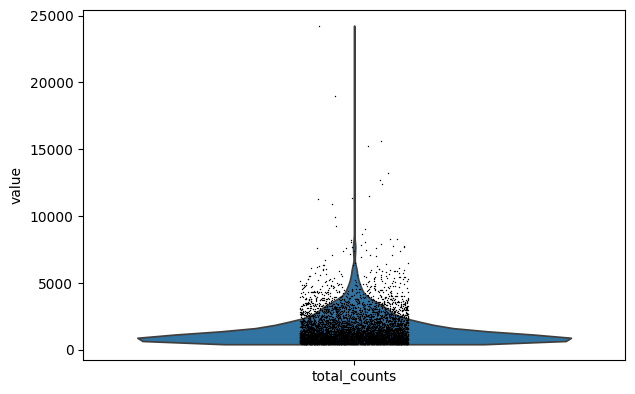

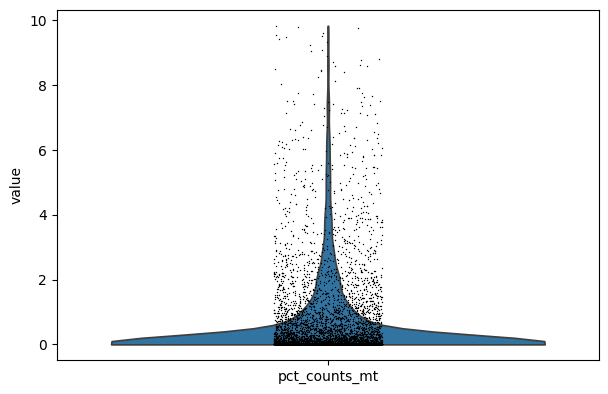

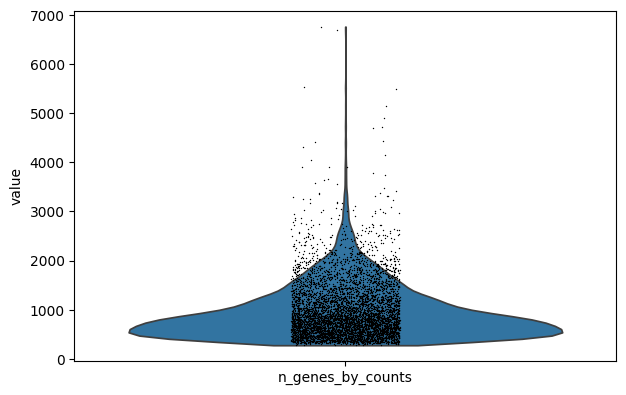

In [50]:
# plot "n_genes_by_counts", "total_counts" and "pct_counts_mt"
sc.pl.violin(adata, 'total_counts')
sc.pl.violin(adata, "pct_counts_mt")
sc.pl.violin(adata, "n_genes_by_counts")

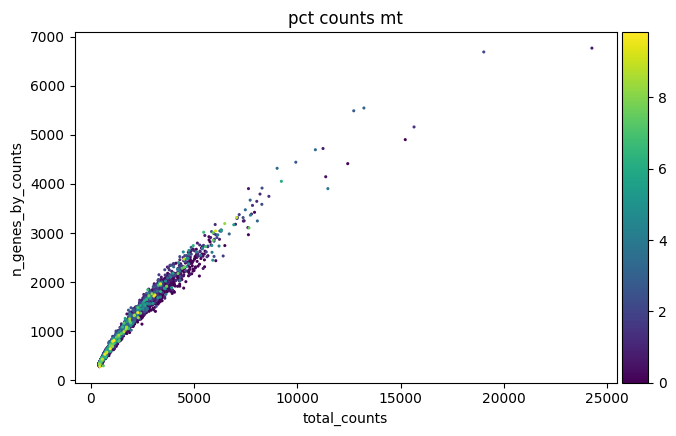

In [49]:
# Plot multiple variable
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [ ]:
# import numpy as np
# from scipy.stats import median_abs_deviation
# import scanpy as sc

# # Define a function to determine outliers based on MAD
# def is_outlier(adata, metric: str, nmads: int):
#     """
#     Identify outliers in an AnnData object based on a given metric and a threshold of MADs.

#     Parameters:
#         adata: AnnData object.
#         metric: Metric column name in adata.obs to assess.
#         nmads: Number of MADs to use as the permissive threshold.

#     Returns:
#         A boolean array where True indicates outliers.
#     """
#     M = adata.obs[metric]
#     outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
#         M > np.median(M) + nmads * median_abs_deviation(M)
#     )
#     return outlier

# # Apply the is_outlier function to the specified QC metrics
# adata.obs["outlier"] = (
#     is_outlier(adata, "log1p_total_counts", 5)
#     | is_outlier(adata, "log1p_n_genes_by_counts", 5)
#     | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
# )

# # Count the number of cells flagged as outliers
# print(adata.obs.outlier.value_counts())

# # Apply the is_outlier function for mitochondrial percentages with specific thresholds
# adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
#     adata.obs["pct_counts_mt"] > 8
# )

# # Count the number of cells flagged as mitochondrial outliers
# print(adata.obs.mt_outlier.value_counts())

# # Print initial number of cells
# print(f"Total number of cells: {adata.n_obs}")

# # Filter the AnnData object to exclude outliers
# adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

# # Print the number of cells after filtering
# print(f"Number of cells after filtering of low-quality cells: {adata.n_obs}")

# # Plot total counts vs. number of genes by counts, coloring by mitochondrial percentage
# p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")


# Wrangle Data

explain

# Explore Data

explain

# Analyze Data

explain

# Conclusions

## Discoveries

explain

## Future Directions

explain

# End

## Show Session Information

In [7]:
import session_info
session_info.show()

## Save Session Requirements

In [8]:
# Replace spaces in notebook title with underscores
filename = Notebook_title.replace(" ", "_") + "_requirements.txt"

# Run the pip freeze command and save the output txt file
!pip freeze > $filename